# Load libraries & data

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

In [3]:
# Rebuild text
from sklearn_bridge import recreate_text_representation
# take text + labels from train ds
from sklearn_bridge import candidate_dict_to_df

In [4]:
from MLutils import report_to_df, train_evaluate, diversity_heatmap

In [5]:
import sklearn, pickle, time, seaborn
import pandas as pd
from itertools import product

In [6]:
with open('candidates_TrainValTestOutgoing.pickle', 'rb') as f:
    candidate_dict = pickle.load(f)

for splt in candidate_dict.keys():
    print "Split = %i : imported %i candidates" %(splt, len(candidate_dict[splt].keys()))

Split = 0 : imported 12987 candidates
Split = 1 : imported 3230 candidates
Split = 2 : imported 8335 candidates
Split = 3 : imported 79400 candidates


# Set pipeline options

In [7]:
# TODO: run again for no trimming

In [8]:
#TODO: Implement:
# shortest dependency path
# feature combination

In [14]:
shortest_dep_paths = [False, True]
trimmings = [(False,0), 
             #(True,0), 
             (True, 5)
            ]
use_lemmas_ = [True, 
               False]
random_undersample_ = [True]
text_vectorizer_ = [CountVectorizer(binary=True, min_df=1 , stop_words='english', ngram_range=(0,3)),
                    CountVectorizer(binary=True, min_df=1 , stop_words=None, ngram_range=(0,3)),
#                     CountVectorizer(binary=True, min_df=1 , ngram_range=(0,3)),
                    
# #                    CountVectorizer(binary=True, min_df=5 , stop_words='english'),
                    TfidfVectorizer(binary=False, min_df=1 , stop_words='english', ngram_range=(0,3) ),
                    TfidfVectorizer(binary=False, min_df=1 , stop_words=None, ngram_range=(0,3) ),
#                     TfidfVectorizer(binary=False, min_df=1 , ngram_range=(0,3) ),
# #                     TfidfVectorizer(binary=True, min_df=5 , stop_words='english'),
                   ]
lsa_dims = [100]


In [15]:
# select models to train
models = {
    'LogisticRegression': LogisticRegression(),
    'SVC_linear': SVC(kernel = 'linear'),
# # #     'SVC_rbf': SVC(kernel = 'rbf'),
# # #     'SVC_rbf_C=100': SVC(kernel = 'rbf', C=100),
    'SVC_rbf_C=500': SVC(kernel = 'rbf', C=500),
# # #     'SVC_rbf_C=1000': SVC(kernel = 'rbf', C=1000),
#     'kNN_5': KNeighborsClassifier(),
#     'kNN_25': KNeighborsClassifier(n_neighbors=25),
#     'kNN_2': KNeighborsClassifier(n_neighbors=2),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, max_depth=5),
    'NeuralNet(10,10)' : MLPClassifier(hidden_layer_sizes=(10,10)),
#     'NeuralNet(50,50,50)' : MLPClassifier(hidden_layer_sizes=(50,50,50)),
#     'BernoulliNB': BernoulliNB(),
}


In [16]:
combs = product(trimmings,use_lemmas_, random_undersample_, text_vectorizer_, lsa_dims, shortest_dep_paths)
combs = list(combs)
print len(combs)*len(models)


40


# Perform training

In [17]:
import imblearn
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
# import numpy as np
from scipy.sparse import hstack
from MLutils import get_positive_logit, logits_to_bin_labels, logits_to_neg_labels, classif_report_from_dicts

In [18]:
debug=False
start_time = time.time()
for comb in combs: 
    
    #pass pipeline selections
    (trim_text,trim_window) = comb[0]
    use_lemmas = comb[1]
    random_undersample = comb[2]
    text_vectorizer = comb[3]
    lsa_dims = comb[4]
    shortest_dep_path = comb[5]
    
    # determine name
    pkl_name = 'results_dict,'
    if shortest_dep_path:
        pkl_name += 'ShortDepPath,'
    elif trim_text:
        pkl_name += 'trim='+str(trim_window)+','
    if use_lemmas:
        pkl_name += 'lemmas'+','
    if random_undersample:
        pkl_name += ',RuS'+','
    #CV, TFIDF
    if isinstance(text_vectorizer, TfidfVectorizer):
        pkl_name += ',TfIdf_'+','
    elif isinstance(text_vectorizer, CountVectorizer):
        pkl_name += ',CV_'+','      
    if text_vectorizer.binary:
        pkl_name += 'bin_'+','
    if text_vectorizer.min_df:
        pkl_name += 'minFreq='+str(text_vectorizer.min_df)+','
    if text_vectorizer.stop_words:
        pkl_name += '_stopw='+str(text_vectorizer.stop_words)+','
    if text_vectorizer.ngram_range:
        pkl_name += '_ngrams='+str(text_vectorizer.ngram_range)+','
    if lsa_dims:
        pkl_name += ',LSA'+str(lsa_dims)+','
    pkl_name = pkl_name.replace(',,',',')
    
    # Debug pkl name
    if debug:
        print pkl_name
        continue
    
    
    print 'Saving as: \n'+pkl_name.strip(',')+'.pkl'
    print time.time() - start_time
    print ''
    
    if None:
        #reload from pickle df_train,val,test etc
        with open('SDP_df_TrainValTestUnlab.pickle' , 'rb') as f:
            (df_train1, df_val1, df_test1, df_unlab1) = pickle.load(f)
            
    else:
        # create train/test set
        df_train = candidate_dict_to_df(candidate_dict[0],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
        df_val = candidate_dict_to_df(candidate_dict[1],trim_text=trim_text, window=trim_window, lemmas =  use_lemmas,shortest_dep_path = shortest_dep_path )
        df_test = candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
        df_unlab = candidate_dict_to_df(candidate_dict[3],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
    
    
    # get indices (only for val, test, unlab) to zip with results in a dict
    val_ids = list(df_val.index)
    test_ids = list(df_test.index)
    unlab_ids = list(df_unlab.index)
    
    
    
    #TODO: move random undersampling here (will fasten up algorithm)
    
    # text 2 matrix (CV/TF-idf)
    X_train = text_vectorizer.fit_transform(df_train.text)
    y_train = df_train.label
    

    X_val = text_vectorizer.transform(df_val.text)
#     y_val = df_val.label # To delete    
    
    X_test = text_vectorizer.transform(df_test.text)
#     y_test = df_test.label # To delete
    
    X_unlab = text_vectorizer.transform(df_unlab.text)
#     y_unlab = df_unlab.label # To delete
    
    
    #new
    y_val_gold = dict(df_val.label)
    y_test_gold = dict(df_test.label)

    
    # LSA
    if lsa_dims: #TODO save in diff. matrix to append later?
        svd = TruncatedSVD(n_components=lsa_dims)
        X_train_svd = svd.fit_transform(X_train)
        X_val_svd = svd.transform(X_val)
        X_test_svd = svd.transform(X_test)
        X_unlab_svd = svd.transform(X_unlab)
        
        
        if True:#TODO replace with concat keyword
            X_train = hstack((X_train,X_train_svd))
            X_val = hstack((X_val,X_val_svd))
            X_test = hstack((X_test,X_test_svd))
            X_unlab = hstack((X_unlab,X_unlab_svd))
    
    # undersampling
    if random_undersample:
#         print('Original dataset shape {}'.format(Counter(y_train)))
        rus = RandomUnderSampler(random_state=42)
        X_train, y_train = rus.fit_sample(X_train, y_train)
#         print('Resampled dataset shape {}'.format(Counter(y_train)))

    # train/predict, construct results_dict
    results_dict = dict()
    for model_name,model in models.iteritems():
        print 'Training',model_name
#         start_time = time.time()

        try:
            model.probability = True
        except:
            pass
        
        #train & predict
        model.fit(X_train,y_train)
        positive_class_position = list(model.classes_).index(1) #either 0 or 1, depending on model.classes_ (used to get + logits)
        
        # val predictions
#         y_val_pred_bin = model.predict(X_val)
#         y_val_pred_prob = pd.Series(map(lambda x: x[positive_class_position],model.predict_proba(X_val)),index=y_val.index).to_dict()
#         # test predictions
# #         y_test_pred_bin = model.predict(X_test)
#         y_test_pred_prob = pd.Series(map(lambda x: x[positive_class_position],model.predict_proba(X_test)),index=y_test.index).to_dict()
#         # unlab set predictions
# #         y_unlab_pred_bin = model.predict(X_unlab)
#         y_unlab_pred_prob = pd.Series(map(lambda x: x[positive_class_position],model.predict_proba(X_unlab)),index=y_unlab.index).to_dict()
        
        
        
        #TODO: get probability labels in consistent way. which class is true if proba > 0.5???
        
        logits = model.predict_proba(X_val)
        y_val_pred_pos_logit = dict(zip(val_ids, get_positive_logit(logits, positive_class_position)))
        # To delete
#         y_test_pred_bin = dict(zip(val_ids, logits_to_bin_labels(logits))) #only used for evaluation
        y_val_pred_neg = dict(zip(val_ids, logits_to_neg_labels(logits))) #only used for evaluation
        
        #save classif report
        class_report = report_to_df(
            classif_report_from_dicts(y_val_gold, y_val_pred_neg)
                                 )
        print class_report
        
        # perform predictions for the rest of the data
        logits = model.predict_proba(X_test)
        y_test_pred_pos_logit = dict(zip(test_ids, get_positive_logit(logits, positive_class_position)))
        
        logits = model.predict_proba(X_unlab)
        y_unlab_pred_pos_logit = dict(zip(unlab_ids, get_positive_logit(logits, positive_class_position)))
        
#         To delete
#         logits = model.predict()
#         y_test_pred_pos_logit = dict(zip(test_ids, get_positive_logit(logits)))
#         y_test_pred_bin = dict(zip(val_ids, logits_to_bin_labels(logits))) #only used for evaluation
#         y_test_pred_neg = dict(zip(val_ids, logits_to_neg_labels(logits))) #only used for evaluation
        
        
        # TODO: do smth for later, when true lbls not in place.
        
        results_dict[model_name] = {
                                    "label_val_prob+" : y_val_pred_pos_logit,
                                   "label_test_prob+" : y_test_pred_pos_logit,
                                   "label_unlab_prob+" : y_unlab_pred_pos_logit,
                                    "classification_report": class_report,
                                    "f1+": class_report.loc['1','f1-score']
            
#                                     "label_val_binary" : y_val_pred_bin,
#                                     "label_val_prob_dict" : y_val_pred_prob,
#                                     "label_test_binary" : y_test_pred_bin,
#                                     "label_test_prob_dict" : y_test_pred_prob,
#                                     "label_unlab_binary" : y_unlab_pred_bin,
#                                     "label_unlab_prob_dict" : y_unlab_pred_prob,
#                                     #only possible when true labels in place:
# #                                     "confusion_matrix" : conf_matrix,
#                                     "classification_report": class_report,
#     #                                 "precision": class_report.loc['avg/total','precision'],
#     #                                 "recall": class_report.loc['avg/total','recall'],
#                                     "f1+": class_report.loc['1','f1-score'],
#                                     "model_classes": model.classes_

                                   }
#         print "%s done. (%.2f sec)"%(model_name,time.time()-start_time)
    #save predictions in dict
    with open('ml_predictions/'+pkl_name+'.pkl', 'wb') as f:
        pickle.dump(results_dict,f)
        
#     diversity_heatmap(results_dict, title = pkl_name)

Saving as: 
results_dict,RuS,CV_,bin_,minFreq=1,_stopw=english,_ngrams=(0, 3),LSA100.pkl
0.0142011642456

Training SVC_rbf_C=500
           precision  recall  f1-score  support
Classes                                        
-1              0.90    0.75      0.82     2525
1               0.45    0.71      0.55      705
avg/total       0.80    0.74      0.76     3230
Training LogisticRegression
           precision  recall  f1-score  support
Classes                                        
-1              0.90    0.77      0.83     2525
1               0.46    0.69      0.55      705
avg/total       0.80    0.76      0.77     3230
Training SVC_linear
           precision  recall  f1-score  support
Classes                                        
-1              0.89    0.75      0.81     2525
1               0.42    0.66      0.51      705
avg/total       0.78    0.73      0.75     3230
Training NeuralNet(10,10)
           precision  recall  f1-score  support
Classes                      

IOError: [Errno 2] No such file or directory: 'SDP_df_TrainValTestUnlab.pickle'

# ~

### For saving shortest dependency path matrix (takes ~30 mins to compute)

In [ ]:

# # candidate_dict_to_df(candidate_dict[2],trim_text=trim_text, window=trim_window, lemmas = use_lemmas ,shortest_dep_path = shortest_dep_path)
# with open('SDP_df_TrainValTestUnlab.pickle' , 'wb') as f:
#     pickle.dump((df_train, df_val, df_test, df_unlab), f)

# Explore diversity between classifiers

In [ ]:
# from sklearn.metrics import cohen_kappa_score
# from matplotlib import pyplot as plt

In [46]:
from MLutils import diversity_heatmap
from sklearn.metrics import accuracy_score, cohen_kappa_score

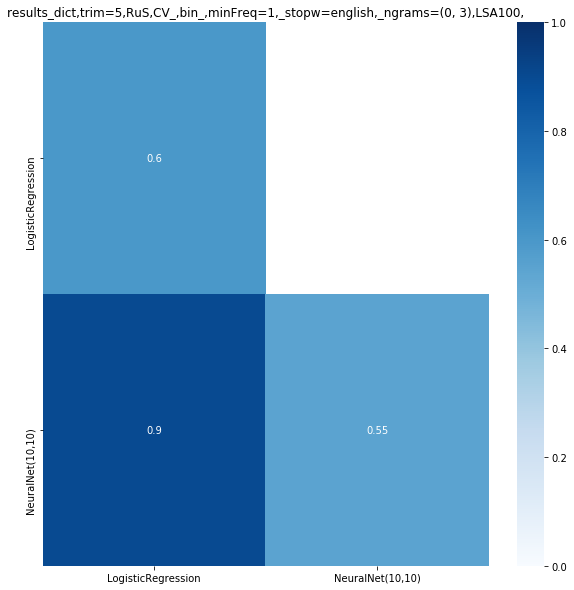

In [57]:
diversity_heatmap(results_dict, title = pkl_name, metric=accuracy_score)

In [32]:
# #whats going on with svc poly etc

# cohen_kappa_score(results_dict['SVC_poly3_C=100']['label_binary'],
#                  results_dict['SVC_poly3_C=1000']['label_binary'])
# #bcause results are same -> nan ?? 


In [37]:
# results_a = SVC(kernel = 'rbf', C=1000).fit(X_train_dev,y_train_dev).predict(X_test)
# results_b = SVC(kernel = 'linear').fit(X_train_dev,y_train_dev).predict(X_test)


In [28]:
# ## Check cohens kappa for individual models
# def cohens_kappa_quick_check(model1,model2):
#     """
#     Returns Cohens kappa interannotator agreement between on two models
#     (after training on dev+train and predicting in X_test)
#     """
#     results_a = model1.fit(X_train_dev,y_train_dev).predict(X_test)
#     results_b = model2.fit(X_train_dev,y_train_dev).predict(X_test)
#     return cohen_kappa_score(results_a, results_b)


# cohens_kappa(SVC(kernel = 'rbf', C=1000),
#              SVC(kernel = 'linear'))

# cohens_kappa(SVC(kernel = 'rbf', C=1000),
#              SVC(kernel = 'rbf', C=500),
#             )